In [1]:
import numpy as np
import argparse
import c3.libraries.fidelities as fidelities
from utils import *
import c3.libraries.algorithms as algorithms
from SingleQubitExperiment import SingleQubitExperiment

2021-10-05 16:57:23.341965: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-05 16:57:23.342004: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("output", help="Output directory")
args = parser.parse_args()
output_dir = args.output
#output_dir = './output'

In [3]:
def spectral_peaks_goal(propagators: dict, instructions: dict, index, dims,
                        qubit: chip.Qubit, generator: Generator, drive: chip.Drive,
                        n_eval=-1, num_peaks=2) -> tf.Tensor:
    # find energies of the qubit
    energies = qubit.get_Hamiltonian().numpy().diagonal().real
    vec1 = np.array([energies[3] - energies[2], energies[1] - energies[0]]) / (2 * np.pi)

    infids = []
    for gate, propagator in propagators.items():
        # create signal and find peaks
        instr = instructions[gate]
        signal = generator.generate_signals(instr)[drive.name]
        peakFrequencies, peakValues = findFrequencyPeaks(signal["ts"].numpy(), signal["values"].numpy(), num_peaks)
        peakFrequencies = tf.convert_to_tensor(peakFrequencies)
        peakValues = tf.convert_to_tensor(peakValues)

        # add frequency offsets to infidelity
        #infid = np.linalg.norm(vec1 - peakFrequencies)
        infid1 = tf.abs(vec1[0] - peakFrequencies[0]) / peakFrequencies[0]
        infid1 += tf.abs(vec1[1] - peakFrequencies[1]) / peakFrequencies[1]

        # add peak height difference to infidelity
        if peakFrequencies[1] > peakFrequencies[0]:
            a = peakValues[1]
            b = np.sqrt(2) * peakValues[0]
        else:
            a = peakValues[0]
            b = np.sqrt(2) * peakValues[1]
        infid2 = tf.abs(a - b) / tf.maximum(a, b)
        infid = infid1 * (1 + infid2)
        infids.append(infid)
    result = tf.reduce_mean(infids)
    print("type: ", type(result))
    return result


def printInformation(exper: SingleQubitExperiment, name: str) -> None:
    signal = exper.generateSignal()
    peakFrequencies, peakValues = findFrequencyPeaks(signal["ts"].numpy(), signal["values"].numpy(), 4)
    print("peaks: ", np.sort(peakFrequencies))
    exper.plotSignal("signal_" + name)
    exper.plotTimeEvolution("populations_" + name)
    exper.plotPropagator("propagator_" + name)


def setOptimalValues(envelope: pulse.Envelope, params: dict) -> None:
    for key, value in params.items():
        envelope.params[key].set_value(value)

In [4]:
'''
optimal_values = {
    "amp": 0.5982053163520968,
    #"sigma": 0.020022993947430123,
    "xy_angle": -1.855052604814916,
    "freq_offset": -54371228.73199173,
    "delta": -0.14784432135434766,
    #"carrier-freq": 5222459053.481677,
    #"framechange": 2.5942825630048745
}
inphase = tf.convert_to_tensor([0.2860119617309102, 0.2515755091876439, 0.173873025201375, 0.0007877386279906926, 0.013990268564515115, 1.0829353284431187, 0.12363579320739716, 0.533448750207164, 0.8241718971826906, 1.0126588320674026, 0.14054899938732912, 0.4154462095036047, 0.27790851911436115, 0.23695097592812822, 0.77387916183715, 0.13882356089751952, 0.17031455162574796, 0.015579040202510648, 0.10100116240706104, 0.8967235745253517, 0.2340774787995677, 0.4065161651870501, 0.14357762493498727, 0.9778244879245249, 0.21827392144642413, 0.7419575443378293, 0.9844786602582266, 0.774177092939803, 1.034049069101188, 0.8755064255501308, 0.6625810857937209, 0.5166892426294151, 1.0869475685574725, 1.0267639229288643, 0.9169247779955447, 0.05928266478720349, 0.375552034589335, 0.1452760805899441, 0.8011251527567873, 0.1722525872387966, 0.6124577751630437, 0.15228718221912907, 0.013159047422195423, 0.2084289367907402, 0.965936486818863, 0.4794322168470483, 7.777490527675845e-05, 1.0527621402872498, 0.5854932409328775, 0.8591261219539706, 0.27456047754898577, 0.03254927163527047, 0.8025139099221452, 1.0105039386343857, 0.9750845205896466, 0.06200624813674867, 0.3584582169425935, 0.4312511943969614, 0.6545680324609726, 0.18879975173915983])
'''

freq = 5e9  #5222459053.481677
anharm = 300e6
t_final = 25e-9
sigma = t_final / 5  #0.020022993947430123
#sigma2 = sigma / 2
#relative_amp = 2
carrier_freq = 4.7e9
#optimisable_params_1 = {
#    "custom": [
#        "amp", "sigma",
#        "cosine_frequency",
#        "xy_angle", "freq_offset",  # for single gaussian envelope
#        "t_final",
#        #"delta",  # for DRAG
#    ],
#    "carrier": [
#        "freq",
#        "framechange"
#    ]
#}
optimisable_params = {
    "pwc": [
        "amp",
        #"cosine_frequency",
        "xy_angle", "freq_offset",
        "delta",
        #"t_final", "t_bin_start", "t_bin_end",
        "inphase"
    ],
    "carrier": [
        "freq",
        "framechange"
    ]
}
#custom_params = {
#    "amp": 0.485342,
#    "xy_angle": -0.050221,
#    "freq_offset": -53e6,
#}

In [6]:
callback = lambda infid: print(infid)

for i in range(3):
    envelope = createPWCGaussianPulse(t_final, sigma, 30)
    #envelope = createPWCCustomPulse(t_final, sigma=1.794e-9, cosine_frequency=303.160e6, num_pieces=60, custom_params=custom_params)
    exper = SingleQubitExperiment(directory=f"{output_dir}/", file_suffix=f"{i}")
    exper.prepare(t_final, freq, anharm, carrier_freq, envelope, useDrag=True)

    # print information
    energies = exper.getEnergies()
    print("energies: ", [(energies[i + 1] - energies[i]) / (2 * np.pi) for i in range(len(energies) - 1)])
    printInformation(exper, "before")

    # first optimisation
    params_after = exper.optimise(
        optimisable_params,
        algorithm=algorithms.lbfgs_grad_free,
        algorithm_options={
            #"stop_at_convergence": 15,
            #"spread": 0.2,
            #"popsize": 25,
            "maxfun": 150,
        },
        fidelity_function=fidelities.unitary_infid_set,
        fidelity_params={
            "active_levels": 4,
            #"qubit": exper.getQubit(),
            #"generator": exper.getExperiment().pmap.generator,
            #"drive": getDrive(exper.getExperiment().pmap.model, exper.getQubit())
        },
        callback=callback,
    )
    printInformation(exper, "after")
    print(params_after)

    # second experiment
    '''
    envelope2 = createPWCCustomPulse(t_final, optimisedParams['lower-X[0]-d1-custom-sigma'], optimisedParams['lower-X[0]-d1-custom-cosine_frequency'], 30)
    exper2 = SingleQubitExperiment(directory=f"{output_dir}/", file_suffix=f"{i}")
    carrier_freq2 = optimisedParams['lower-X[0]-d1-carrier-freq']
    exper2.prepare(t_final, freq, anharm, carrier_freq2, envelope2, useDrag=False)

    # second optimisation
    callback = lambda infid: print("infidelity: ", infid)
    params_after = exper.optimise(
        optimisable_params,
        algorithm=algorithms.lbfgs,
        algorithm_options={
            #"stop_at_convergence": 15,
            #"spread": 0.15,
            #"popsize": 20,
            "maxfun": 100
        },
        fidelity_function=fidelities.unitary_infid_set,
        fidelity_params={
            "active_levels": 4,
        },
        callback=callback
    )
    printInformation(exper, "after")
    print(params_after)
    '''

NameError: name 'output_dir' is not defined

[[0.70710678+0.j         0.        -0.70710678j 0.        +0.j
  0.        -0.j        ]
 [0.        -0.70710678j 0.70710678+0.j         0.        -0.j
  0.        +0.j        ]
 [0.        +0.j         0.        -0.j         0.70710678+0.j
  0.        -0.70710678j]
 [0.        -0.j         0.        +0.j         0.        -0.70710678j
  0.70710678+0.j        ]]
saving plot in /home/user/test1.png


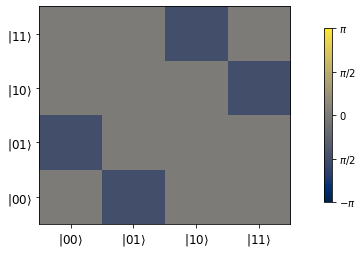

In [3]:
import c3.libraries.constants as constants
import c3.utils.qt_utils as qt_utils
ideal = qt_utils.np_kron_n([constants.Id, constants.x90p])
print(ideal)

plotMatrix(ideal, "/home/user/test1.png")